In [1]:
%pylab inline
import numpy as np
import scipy as sc
import pandas as pd

import seaborn as sns
#sns.set_style("whitegrid")
#sns.set_context("talk")
#rc('axes', labelsize=20, titlesize=20)

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import math
import scipy.stats as ss

import pickle
import gc 
import timeit
from ABC_algorithm import ABC

Populating the interactive namespace from numpy and matplotlib


:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
######
# set up for the normal ABC example
######

prior_mean = -4.0
prior_sd = 3
likelihood_sd = 1

def NormalPriorSampler(n):
    return np.random.normal(loc=prior_mean, scale=prior_sd, size=n)

def NormalLiklihoodSimulator(n, param):
    #unknown mean
    return np.random.normal(loc=param, scale=likelihood_sd, size=n)
    
def NormalSummary(data):
    return np.mean(data, axis=0)

data = np.random.normal(loc=0,scale=likelihood_sd,size=100)

In [3]:
######
# set up for the g and k distribution
######

def SimulateGK(n, param):  #B>0, K>-1/2 #param is a vector of A, B, g, k
    A, B, g, k = param[0], param[1], param[2], param[3]
    u_values = np.random.uniform(low=0.0, high=1.0, size=n)
    x_values = np.zeros(n)
    for i in range(0,n):
        x_values[i] = A + B*(1+0.8*(1-np.exp(-g*sc.stats.norm.ppf(u_values[i], 0, 1) )) /(1 + np.exp(-g*sc.stats.norm.ppf(u_values[i], 0, 1) ))) *np.power((1+ np.power(sc.stats.norm.ppf(u_values[i], 0, 1),2)),k)*(sc.stats.norm.ppf(u_values[i], 0, 1))    
    return x_values

def GKPriorSampler(n):
    l = []
    for i in range(n):
        l.append(np.random.uniform(low=0.0, high=10.0, size=4)) # we assume uniform [1,10] prior for all 4 parameters
    return l

def GKLiklihoodSimulator(n, param):
    #unknown mean
    return SimulateGK(n, param)
    
def GKSummary(data):
    return np.sort(data)


data_gk = SimulateGK(100, [3, 1, 2, 0.5])

In [6]:
start_time = timeit.default_timer()
ABC(GKPriorSampler, GKLiklihoodSimulator, GKSummary, 1000, data_gk , 200)
print(timeit.default_timer() - start_time)

10.7002675190015


In [22]:
epsilon_seq = np.linspace(start=0, stop=10, num = 100)
n = 10000
k = 20
accepted_ratio = []
#Run abc with these epsilon and get the ratio of accepted samples
output_list = []

for eps in epsilon_seq:
    print eps
    aux = 0
    for rep in range(k):
        ABC_run = ABC(NormalPriorSampler, NormalLiklihoodSimulator, NormalSummary, eps, data , n)
        output_dict = {'eps': eps, 'accept ratio':sum(ABC_run.accept)/float(n)}
        output_list.append(output_dict)
        aux=aux+sum(ABC_run.accept)/n
    accepted_ratio.append(aux/k)
    
pickle.dump(output_list, open( "data/acceptance_rate_normal.p", "wb" ) )

0.0
0.10101010101
0.20202020202
0.30303030303
0.40404040404
0.505050505051
0.606060606061
0.707070707071
0.808080808081
0.909090909091
1.0101010101
1.11111111111
1.21212121212
1.31313131313
1.41414141414
1.51515151515
1.61616161616
1.71717171717
1.81818181818
1.91919191919
2.0202020202
2.12121212121
2.22222222222
2.32323232323
2.42424242424
2.52525252525
2.62626262626
2.72727272727
2.82828282828
2.92929292929
3.0303030303
3.13131313131
3.23232323232
3.33333333333
3.43434343434
3.53535353535
3.63636363636
3.73737373737
3.83838383838
3.93939393939
4.0404040404
4.14141414141
4.24242424242
4.34343434343
4.44444444444
4.54545454545
4.64646464646
4.74747474747
4.84848484848
4.94949494949
5.05050505051
5.15151515152
5.25252525253
5.35353535354
5.45454545455
5.55555555556
5.65656565657
5.75757575758
5.85858585859
5.9595959596
6.06060606061
6.16161616162
6.26262626263
6.36363636364
6.46464646465
6.56565656566
6.66666666667
6.76767676768
6.86868686869
6.9696969697
7.07070707071
7.17171717172
7.2

"\nprint(accepted_ratio)\nplt.plot(epsilon_seq, accepted_ratio, '-')\nplt.xlabel(r'$\\epsilon$', fontsize=18)\nplt.ylabel('Acceptance rate', fontsize=18)\nplt.savefig('plots/TAR_curve_normal.pdf')\nplt.show()\n"

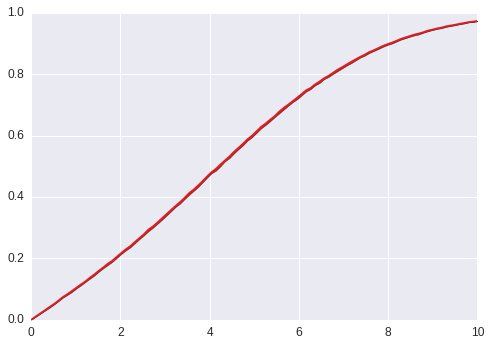

In [42]:
df_normal = pd.DataFrame(output_list)
df_normal_mean = df_normal.groupby("eps", as_index=False).mean()
df_normal_var = df_normal.groupby("eps", as_index=False).var()


plt.plot(df_normal_mean.eps, df_normal_mean["accept ratio"], '-')
plt.fill_between(df_normal_mean.eps, df_normal_mean["accept ratio"]-sqrt(df_normal_var["accept ratio"]),
                 df_normal_mean["accept ratio"]+sqrt(df_normal_var["accept ratio"]))

'''
print(accepted_ratio)
plt.plot(epsilon_seq, accepted_ratio, '-')
plt.xlabel(r'$\epsilon$', fontsize=18)
plt.ylabel('Acceptance rate', fontsize=18)
plt.savefig('plots/TAR_curve_normal.pdf')
plt.show()
'''

In [8]:
## TAR curve for g and k distribution
epsilon_seq = np.linspace(start=0, stop=5000, num = 50)
n = 200
k = 20
counter = 0
accepted_ratio = []
output_list = []
#Run abc with these epsilon and get the ratio of accepted samples

for eps in epsilon_seq:
    print(float(counter/len(epsilon_seq))*100,"%")
    counter += 1
    aux = 0
    for rep in range(k):
        ABC_run = ABC(GKPriorSampler, GKLiklihoodSimulator, GKSummary, eps, data_gk , n)
        output_dict = {'eps': eps, 'accept ratio':sum(ABC_run.accept)/float(n)}
        output_list.append(output_dict)
        aux=aux+sum(ABC_run.accept)/n
    accepted_ratio.append(aux/k)
    
print("DONE :D")
    
pickle.dump(output_list, open( "data/acceptance_rate_gk.p", "wb" ) )

0.0 %
10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
DONE :D


[0.0, 0.165, 0.23, 0.26, 0.265, 0.285, 0.28, 0.3, 0.285, 0.3]


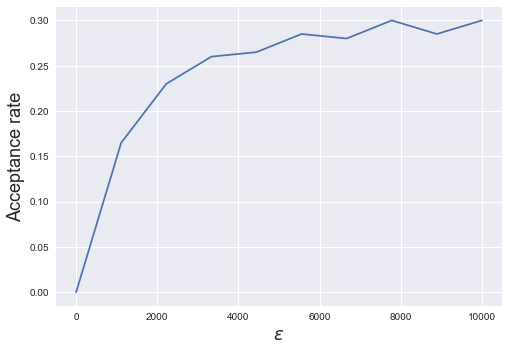

In [9]:
print(accepted_ratio)
plt.plot(epsilon_seq, accepted_ratio, '-')
plt.xlabel(r'$\epsilon$', fontsize=18)
plt.ylabel('Acceptance rate', fontsize=18)
plt.savefig('plots/TAR_curve_gk_distribution.pdf')
plt.show()